<a href="https://colab.research.google.com/github/RiniChandra7/TargetlessDrugDiscoveryPipeline/blob/main/Final_Targetless.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-requisites
Please ensure that the necessary uploads are available, and their correct paths are present in Code blocks 18, 20, 21, 22 & 23.
Also ensure that the input SMILES list is either uploaded in the session storage or present in your Google drive (mounting will be required in this case - see Section 2), and the correct path for it is updated in Code block 6.

The necessary uploads are available here - https://drive.google.com/drive/u/0/folders/1EJ9gKOwCO0Q7hUA3Go8DfG9-nG_VbkLg

# Section 1 - Installation of Dependencies
The following 4 code blocks are responsible for installing the dependencies required for running this code in the Google Colab environment.

The first 2 code blocks are concerned with creation of a conda environment within Colab followed by importing the necessary dependencies from RDKit, which is necessary to avoid issues that have been faced when trying to make RDKit work in Colab. The import has been done beforehand because it has been observed that RDKit crashes on direct imports sometimes, in Google Colab. Special thanks to the authors of the resources specified in the comments in code block 1 & 2, due to which this issue could be alleviated.

Code block 3 is concerned with the installation of the nightly build of DeepChem, which ensures that the freshest updates are picked.

Code block 4 installs RateLimit, which is useful in controlling API calls to REST APIs that have been used in this project.



In [31]:
!pip install rdkit-pypi

In [32]:
#Code block 2 - Inspired by RDKit troubleshooting tips suggested here (https://stackoverflow.com/questions/65487584/how-to-import-rdkit-in-google-colab-these-days)
#If an ImportError happens and you see the message regarding the runtime being stopped, please run notebook once again. More details about the issue available in the Stack Overflow link specified above.
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

try:
  from rdkit import Chem
  from rdkit.Chem import Descriptors, rdMolDescriptors, rdchem, Crippen, QED, rdmolops
  from rdkit.Chem.rdchem import Mol
  from rdkit.Chem import Lipinski, Draw
except ImportError:
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  exit()

In [33]:
#Code block 3 - Installation of DeepChem nightly build
!pip install --pre deepchem

In [34]:
#Code block 4 - Installation of RateLimit
!pip install ratelimit

#Section 2 - Mount your drive
This is necessary only when the necessary uploads are available in Google drive, and those files need to be retrieved from there. It may be skipped if the files are available in session storage. The necessary uploads are available here - https://drive.google.com/drive/u/0/folders/1EJ9gKOwCO0Q7hUA3Go8DfG9-nG_VbkLg


In [35]:
#Code block 5 - Execute only if the necessary uploads are present in Google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Section 3 - Specify your inputs
Fill up the expectations you have with the resultant candidates in this form below. If you're not clear with regarding any of these requirements, please use the defaults, as follows:


*   Preferred_filter = NA
*   Min_QED = 0
*   Min_Molecular_Weight = 0
*   Max_Molecular_Weight as per your preference (if the value is too large, then it would be reset to the maximum that can be handled by Python automatically).
*   Min_Heavy_Atoms = 0
*   Max_Heavy_Atoms as per your preference (if the value is too large, then it would be reset to the maximum that can be handled by Python automatically).
*   Solubility = NA
*   Reference_Molecule = ""
*   Similarity_type = "Tanimoto" (NA unavailable because you have to pick at least one type of similarity if a reference molecule is present)



In [36]:
#@title Input Properties
Preferred_filter = "Lipinski's Rule of 5" #@param ["NA","Lipinski's Rule of 5", "Drug-Likeness (QED)", "Ghose", "Veber", "REOS", "Rule of 3"]
Min_QED = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
Min_Molecular_Weight = 0 #@param {type:"number"}
Max_Molecular_Weight = 500 #@param {type:"number"}
Min_Heavy_Atoms = 0 #@param {type: "number"}
Max_Heavy_Atoms = 500 #@param {type: "number"}
#Max_SAS = 7 #@param {type:"slider", min:0, max:10, step:1}
Solubility = "Lipophilic" #@param ["NA", "Hydrophilic", "Lipophilic"]
Reference_Molecule = "C" #@param {type:"string"}
Similarity_type = "Tanimoto" #@param ["Tanimoto", "Dice", "Cosine", "Sokal", "McConnaughey"]

# Section 4 - Initial Processing of Candidate pool
The code block 6 is where your input list gets its initial validation done, and the list of authentic compounds are forwarded to the upcoming code.

Make sure to specify the correct path for the text file, with each compound SMILES on a new line, on the first non-comment line of code in this block.

If you wish to use the default list of 2k+ random compounds, then that is available in the 'Necessary Uploads' folder, by the name 'Step1.txt'.

In [37]:
#Code block 6 - Supply the candidate pool here, as a text file.
#Specify the correct path for that file in the first code line.
f = open('/content/drive/MyDrive/Necessary Uploads/TestSet25.txt', 'r')

#This part reads all the unique lines from the input file, where each compound is on a different line
smiles_list = []
smiles_list = f.readlines()
smiles_list = list(map(lambda i: i[ : -1], smiles_list)) 
smiles_list = list(set(smiles_list))

#This part removes all blank compounds from the list
for x in smiles_list:
  if Chem.MolFromSmiles(x) is None or len(x) is 0:
    smiles_list.remove(x)

#Show how many authentic candidates are available
print(str(len(smiles_list)) + " candidates available.")


#No further processing required if there are no candidates in the pool; reset
if (len(smiles_list) <= 0):
  sys.exit('No candidates in the candidate pool.')

25 candidates available.


# Section 5 - Healthcare filters
In code block 7, the healthcare filters like Lipinski's rule of 5, etc. are implemented as functions, to be called in code block 8 for whittling down the list of compounds for which property determination has to be done at later stages.

In [38]:
#Code block 7 - Definition of functions responsible for Filtration pertaining to healthcare
#All filtration functions defined in this block

#Lipinski's rule of 5
def getRo5Props(x):
  smile = ''.join(x)
  if Chem.MolFromSmiles(smile) is not None and len(smile) is not 0:
    m = Chem.MolFromSmiles(smile)
    molecular_weight = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    h_bond_donor = Descriptors.NumHDonors(m)
    h_bond_acceptors = Descriptors.NumHAcceptors(m)

    if molecular_weight <= 500 and logp <= 5 and h_bond_donor <=5 and h_bond_acceptors <= 10:
      return True
    else:
      return False

#Drug-likeness or QED
def getQEDProps(x):
  smile = ''.join(x)
  if Chem.MolFromSmiles(smile) is not None and len(smile) is not 0:
    m = Chem.MolFromSmiles(smile)
    molecular_weight = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    h_bond_donor = Descriptors.NumHDonors(m)
    h_bond_acceptor = Descriptors.NumHAcceptors(m)
    ring_count = Chem.rdMolDescriptors.CalcNumRings(m)
    rotatable_bonds = Descriptors.NumRotatableBonds(m)

    if molecular_weight < 400 and ring_count > 0 and rotatable_bonds < 5 and h_bond_donor <= 5 and h_bond_acceptor <= 10 and logp < 5:
      return True
    else:
      return False

#Ghose
def getGhoseProps(x):
  smile = ''.join(x)
  if Chem.MolFromSmiles(smile) is not None and len(smile) is not 0:
    m = Chem.MolFromSmiles(smile)
    molecular_weight = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    number_of_atoms = Chem.rdchem.Mol.GetNumAtoms(m)
    molar_refractivity = Chem.Crippen.MolMR(m)

    if molecular_weight >= 160 and molecular_weight <= 480 and logp >= -0.4 and logp <= 5.6 and number_of_atoms >= 20 and number_of_atoms <= 70 and molar_refractivity >= 40 and molar_refractivity <= 130:
      return True
    else:
      return False

#Veber
def getVeberProps(x):
  smile = ''.join(x)
  if Chem.MolFromSmiles(smile) is not None and len(smile) is not 0:
    m = Chem.MolFromSmiles(smile)
    rotatable_bonds = Descriptors.NumRotatableBonds(m)
    t_surface_area = Chem.QED.properties(m).PSA

    if rotatable_bonds <= 10 and t_surface_area <= 140:
      return True
    else:
      return False

#REOS
def getREOSProps(x):
  smile = ''.join(x)
  if Chem.MolFromSmiles(smile) is not None and len(smile) is not 0:
    m = Chem.MolFromSmiles(smile)
    molecular_weight = Descriptors.ExactMolWt(m)
    logp = Descriptors.MolLogP(m)
    h_bond_donor = Descriptors.NumHDonors(m)
    h_bond_acceptor = Descriptors.NumHAcceptors(m)
    rotatable_bonds = Descriptors.NumRotatableBonds(m)
    formal_charge = Chem.rdmolops.GetFormalCharge(m)
    heavy_atoms = Chem.rdchem.Mol.GetNumHeavyAtoms(m)

    if molecular_weight >= 200 and molecular_weight <= 500 and logp >= -5 and logp <= 5 and h_bond_donor >= 0 and h_bond_donor <= 5 and h_bond_acceptor >= 0 and h_bond_acceptor <= 10 and formal_charge >= -2 and formal_charge <= 2 and heavy_atoms >= 15 and heavy_atoms <= 50:
      return True
    else:
      return False

#Rule of 3
def getRo3Props(x):
  smile = ''.join(x)
  if Chem.MolFromSmiles(smile) is not None and len(smile) is not 0:
    m = Chem.MolFromSmiles(smile)
    molecular_weight = Descriptors.ExactMolWt(m)
    logp = Descriptors.MolLogP(m)
    h_bond_donor = Descriptors.NumHDonors(m)
    h_bond_acceptor = Descriptors.NumHAcceptors(m)
    rotatable_bonds = Descriptors.NumRotatableBonds(m)

    if molecular_weight <= 300 and logp <= 3 and h_bond_donor <= 3 and h_bond_acceptor <= 3 and rotatable_bonds <= 3:
      return True
    else:
      return False

In [39]:
#Code block 8 - Filtration on inputs via function calls happens here
valid_list = []

if Preferred_filter == "Lipinski's Rule of 5":
  for smiles in smiles_list:
    if getRo5Props(smiles) == True:
      valid_list.append(smiles)
elif Preferred_filter == "Drug-Likeness (QED)":
  for smiles in smiles_list:
    if getQEDProps(smiles) == True:
      valid_list.append(smiles)
elif Preferred_filter == "Ghose":
  for smiles in smiles_list:
    if getGhoseProps(smiles) == True:
      valid_list.append(smiles)
elif Preferred_filter == "Veber":
  for smiles in smiles_list:
    if getVeberProps(smiles) == True:
      valid_list.append(smiles)
elif Preferred_filter == "REOS":
  for smiles in smiles_list:
    if getREOSProps(smiles) == True:
      valid_list.append(smiles)
elif Preferred_filter == "Rule of 3":
  for smiles in smiles_list:
    if getRo3Props(smiles) == True:
      valid_list.append(smiles)
else:
  valid_list = smiles_list

print(str(len(valid_list)) + " molecules have passed the given filter.")

#Processing stops if no candidates make it through the selected filter.
if (len(valid_list) <= 0):
  sys.exit('No candidates made it through the filter.')

19 molecules have passed the given filter.


In [40]:
#Code block 9 - save the results to a csv for future reference, when one wants to see all the compounds that passed the filter
#csv available in session storage
from pandas import DataFrame

df = DataFrame(valid_list, columns=['SMILES'])
df.to_csv('Valid_step2.csv')

# Section 6 - Determination of Computative Properties
Code blocks 10-14 are where the functions for computing properties based on simple computational algorithms are implemented.

In [41]:
#Code block 10 - Functions to determine properties via method 1 i.e. computation
def addQED(x):
  smile = ''.join(x)
  if Chem.MolFromSmiles(smile) is not None and len(smile) is not 0:
    return Chem.QED.qed(Chem.MolFromSmiles(smile))

def addMolecularWeight(x):
  smile = ''.join(x)
  if Chem.MolFromSmiles(smile) is not None and len(smile) is not 0:
    return Chem.Descriptors.MolWt(Chem.MolFromSmiles(smile))

def getCharge(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Chem.rdmolops.GetFormalCharge(Chem.MolFromSmiles(smiles))

def maxPartCharge(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Chem.Descriptors.MaxPartialCharge(Chem.MolFromSmiles(smiles))

def getSize(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return max(map(max, (Chem.rdmolops.GetDistanceMatrix(Chem.MolFromSmiles(smiles)))))

def maxValenceElectrons(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Chem.Descriptors.NumValenceElectrons(Chem.MolFromSmiles(smiles))

def atoms(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Chem.Lipinski.HeavyAtomCount(Chem.MolFromSmiles(smiles))

def rings(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Chem.Lipinski.RingCount(Chem.MolFromSmiles(smiles))

def rotableBonds(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Chem.Lipinski.NumRotatableBonds(Chem.MolFromSmiles(smiles))

def tpsa(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Chem.Descriptors.TPSA(Chem.MolFromSmiles(smiles))

def hDonors(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Chem.Lipinski.NumHDonors(Chem.MolFromSmiles(smiles))

def hAccept(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Chem.Lipinski.NumHAcceptors(Chem.MolFromSmiles(smiles))

def getNumAtoms(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return rdchem.Mol.GetNumAtoms(Chem.MolFromSmiles(smiles))

def getMR(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Crippen.MolMR(Chem.MolFromSmiles(smiles))

In [42]:
#Code block 12 - Similarity tracker
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys

ref = ''.join(Reference_Molecule)
if Chem.MolFromSmiles(ref) is not None and len(ref) is not 0:
  ref_fp = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(ref))

def similarity(x):
  inp = ''.join(x)
  if Chem.MolFromSmiles(inp) is not None and len(inp) is not 0:
    if Similarity_type == "Dice":
      return round(DataStructs.DiceSimilarity(ref_fp, MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(inp))), 3)
    elif Similarity_type == "Cosine":
      return round(DataStructs.CosineSimilarity(ref_fp, MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(inp))), 3)
    elif Similarity_type == "Sokal":
      return round(DataStructs.SokalSimilarity(ref_fp, MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(inp))), 3)
    elif Similarity_type == "McConnaughey":
      return round(DataStructs.McConnaugheySimilarity(ref_fp, MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(inp))), 3)
    else:
      return round(DataStructs.TanimotoSimilarity(ref_fp, MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(inp))), 3)

In [43]:
#Code Block 13 - Compute LogP or solubility as mentioned in the input form
def getLogp(x):
  smiles = ''.join(x)
  if Chem.MolFromSmiles(smiles) is not None and len(smiles) is not 0:
    return Descriptors.MolLogP(Chem.MolFromSmiles(smiles))

In [44]:
#Code block 14 - naming module
#To minimize the time taken by this code block, increase the value of calls. 
#For PubChem API, the value is ideally advised to be 5, but higher ones like 50 have been found to work without issues so far, 
# as 5 is a soft limit.
from urllib.request import urlretrieve
from ratelimit import limits, sleep_and_retry

import requests

@sleep_and_retry
@limits(calls=50, period=1)
def getName(x):
  smiles = ''.join(x)
  if len(smiles) is not 0:
    try:
      urlretrieve('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/'+smiles+'/property/IUPACName/TXT', 'temp.txt')
      n = open('/content/temp.txt', 'r')
      name = n.readlines()
      return name[0]
    except:
      return 'Unknown'

# Section 7 - Filtration based on Properties
Code block 15 is responsible for procuring the values of those properties based on which filtration needs to be done, for all the compounds currently under consideration.

Code block 16 is responsible for input validation, resets if necessary, querying and finalization.

In [45]:
#Code block 15 - Calling functions to determine only those properties based on which the filtration needs to happen.
import sys

df['QED'] = df['SMILES'].apply(addQED)
df['Molecular weight'] = df['SMILES'].apply(addMolecularWeight)

df['Heavy atoms'] = df['SMILES'].apply(atoms)

df['Log P'] = df['SMILES'].apply(getLogp)

#df['SAS'] = df['SMILES'].apply(getSAS)

In [46]:
#Code block 16 - input validation, resets if necessary, querying and finalization
import sys

if Min_Molecular_Weight < 0:
  Min_Molecular_Weight = 0
elif Max_Molecular_Weight > sys.maxsize:
  Max_Molecular_Weight = sys.maxsize

if Min_Heavy_Atoms < 0:
  Min_Heavy_Atoms = 0
elif Max_Heavy_Atoms > sys.maxsize:
  Max_Heavy_Atoms = sys.maxsize

df = df.query('QED>=@Min_QED & `Molecular weight`>=@Min_Molecular_Weight & `Molecular weight`<=@Max_Molecular_Weight & `Heavy atoms`>=@Min_Heavy_Atoms & `Heavy atoms`<=@Max_Heavy_Atoms')
if Solubility == 'Lipophilic':
  df = df.query('`Log P`>=0')
elif Solubility == 'Hydrophilic':
  df = df.query('`Log P`<=0')
else:
  df = df

if len(df) <= 0:
  sys.exit('No candidates available within the valid range.')

# Section 8 - Determination of the other properties
Code blocks 17-24 are responsible for calling the functions previously defined, in order to determine the rest of the computational and predictive properties.


In [47]:
#Code block 17 - Functions calls to the remaining computational property functions
df['Formal charge'] = df['SMILES'].apply(getCharge)
df['Max partial charge'] = df['SMILES'].apply(maxPartCharge)
df['Max Intra-Molecular Distance'] = df['SMILES'].apply(getSize)
df['Valence electrons'] = df['SMILES'].apply(maxValenceElectrons)
df['Rings'] = df['SMILES'].apply(rings)
df['Rotatable bonds'] = df['SMILES'].apply(rotableBonds)
df['TPSA'] = df['SMILES'].apply(tpsa)
df['H-Donors'] = df['SMILES'].apply(hDonors)
df['H-Acceptors'] = df['SMILES'].apply(hAccept)
df['Number of Atoms'] = df['SMILES'].apply(getNumAtoms)
df['Molar Refractivity'] = df['SMILES'].apply(getMR)
if len(Reference_Molecule) is not 0 and Chem.MolFromSmiles(''.join(Reference_Molecule)) is not None:
  df['Similarity'] = df['SMILES'].apply(similarity)

In [48]:
#Code block 18 - Density
#Mean absolute error (ME): 0.0737 on Test dataset with Linear regression
density_er = 0.0737
density_df = df[['Molecular weight', 'Heavy atoms', 'Rings', 'TPSA', 'H-Donors', 'H-Acceptors']]

import pickle 
  
dens = "/content/drive/MyDrive/Necessary Uploads/Necessary Uploads/Density_Model.pkl"  

with open(dens, 'rb') as file:  
    pickled_dens = pickle.load(file)

dens_pred = pickled_dens.predict(density_df)
dens_pred = [(y / 1000.0) for y in dens_pred]

df['Density (g/cm3)'] = dens_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LinearRegression from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [49]:
#Code block 19 - Prep for Graph Convolutional models
import deepchem as dc

pred_smiles = df['SMILES']

from rdkit import Chem
mols = [Chem.MolFromSmiles(t) for t in pred_smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x_r = featurizer.featurize(mols)

In [50]:
#Code block 20 -Dynamic viscosity
#{'graphconvreg': {'mean-pearson_r2_score': 0.9998366136912226}, 'me': 0.6368528911132811, 'mse': 0.6633988550012482}

visc_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', model_dir = "/content/drive/MyDrive/Necessary Uploads/Necessary Uploads/Viscosity model2")
visc = visc_model.predict_on_batch(x_r)

df['Dynamic Viscosity (mPas)'] = visc

In [51]:
#Code block 21 - Vapor pressure
#{'graphconvreg': {'mean-pearson_r2_score': 0.9885580690954194}, 'me': 0.8775332915066647, 'mse': 1.622585033111383} @ 80 epochs

vp_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', model_dir = "/content/drive/MyDrive/Necessary Uploads/Necessary Uploads/VP Model")
vp = vp_model.predict_on_batch(x_r)

df['Log VP'] = vp

In [52]:
#Code block 22 - Dielectric constant
#{'graphconvreg': {'mean-pearson_r2_score': 0.959950395166961}, 'me': 3.922881823396682, 'mse': 25.016039710994534} @ 450 epochs
di_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', model_dir = "/content/drive/MyDrive/Necessary Uploads/Necessary Uploads/Dielectric Constant Model")
di = di_model.predict_on_batch(x_r)

df['Dielectric Constant'] = di

In [53]:
#Code block 23 - ClinTox Toxicity prediction with 90% accuracy @ 1200 epochs
import numpy as np

tox_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', model_dir = "/content/drive/MyDrive/Necessary Uploads/Necessary Uploads/Toxicity Model")
tox = tox_model.predict_on_batch(x_r)

tox = np.abs(tox)
tox = np.round(tox)

for t in tox:
  if t < 0:
    t = 0
  if t > 1:
    t = 1

df['Is Toxic'] = tox

In [54]:
#Code block 24 - Determination of whether the compound is known or unknown, and its name, based on pubchem
df['IUPAC Name'] = df['SMILES'].apply(getName)

df['IUPAC Name'] = df['IUPAC Name'].apply(lambda x: 'Unknown' if len(str(x))<2 else x)

df['Is Known'] = df['IUPAC Name'].apply(lambda x: 0 if x == 'Unknown' else 1)

# Section 9 - Final Output Processing
While code block 25 is responsible for assigning appropriate identifiers to the candidates, code block 26 creates the final output file and adds it to the session storage and code block 27 illustrates the 2D structures of all the molecules present in the final output, with reference to the idenifiers present as 'S. No.' in the output file.

In [55]:
#Code block 25 - Assignment of Indentifiers
df.insert(0, 'S No', range(1, 1 + len(df)))

In [56]:
#Code block 26 - Creation of output csv
df.to_csv("Res.csv")

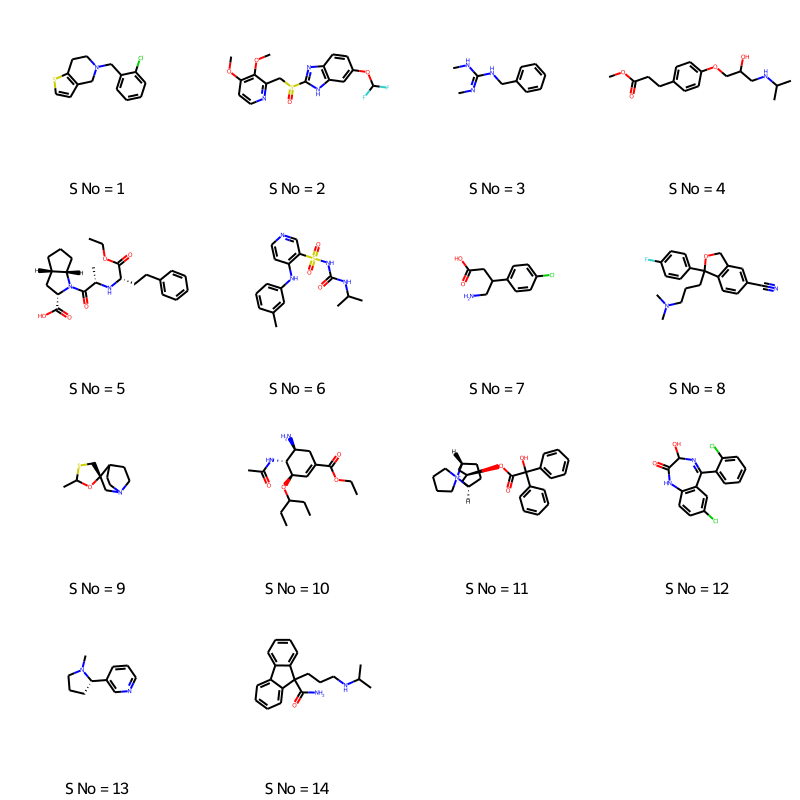

In [57]:
#Code block 27 - Illustration of Chemical structures
mols = [ Chem.MolFromSmiles(''.join(x)) for x in df['SMILES'] ]
Chem.Draw.MolsToGridImage(mols, molsPerRow = 4, subImgSize=(200,200), legends=['S No = ' + str(x) for x in df['S No']] )